In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,r,z_grid,gamma,T):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1+r)*a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1+r)*(wel*0.1)**(-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init=household_guess)
def household(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v):

    c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t

    new_grid = (c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis])
    wel = (1+r)*a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - c
    V_prime = (1+r)*c**(-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        
        c[indexes_asset] = wel[indexes_asset[1]] + z_grid[indexes_asset[0]] + T[indexes_asset[0]] - a[indexes_asset]
        
        V_prime[indexes_asset] = (1+r)*(c[indexes_asset])**(-gamma)
        
    uce = e_grid[:,np.newaxis]*c**(-gamma)

    return V_prime,a,c,uce

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'z_grid', 'e_grid', 'r', 'T', 'beta', 'gamma', 'v', 'Pi']
Macro outputs: ['A', 'C', 'UCE']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'uce']


In [2]:
def income(e_grid, w, N):
    z_grid = w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  (Transfer) / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

print(hh_inp)
print(f'Inputs: {hh_inp.inputs}')
print(f'Outputs: {hh_inp.outputs}')

<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'beta', 'gamma', 'v', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer', 'w', 'N']
Outputs: ['A', 'C', 'UCE']


In [29]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y/Z
    Div = Y - w * N - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return Div,N


@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r,Transfer,B):
    govt_res = (1+r)*B(-1) + Transfer - B
    return govt_res

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w,N,UCE,kw,v,muw):
    phi = (w * N * UCE) / (muw * N ** (1 + v)) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - w * N / muw * UCE)
    
    #vphi = w * UCE / muw / N ** (1 + 1 / v) # their formula
    #wnkpc = vphi * N ** (1 + 1 / frisch) - (1 - tax) * w * UCE / muw
    return wnkpc, phi

@simple 
def auclert_union_ss(w,N,UCE,kw,v,muw):
    phi = (w * UCE) / (muw * N ** (1 + v)) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - w / muw * UCE)
    
    #vphi = w * UCE / muw / N ** (1 + 1 / v) # their formula
    #wnkpc = vphi * N ** (1 + 1 / frisch) - (1 - tax) * w * UCE / muw
    return wnkpc, phi

In [30]:
blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'v', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'B', 'kw', 'muw']


In [31]:
calibration = {'gamma': 1.0, 'v':1.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0,'B':5.6,
                'kw': 0.1, 'muw': 1.1, 'N': 1.0}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [32]:
print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Govt Budget Constrain: {ss0['govt_res']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  6.22e-15
Govt Budget Constrain:  0.00e+00
Goods market clearing (untargeted): -6.67e-09


In [33]:
@simple
def wage(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@simple
def union(piw,w,N,UCE,kw,phi,v,muw,beta):
    wnkpc = kw*(phi*N**(1+v) - w*N/muw*UCE) + beta*(1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log)
    return wnkpc

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name="One-Asset HANK")

In [34]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [35]:
T = 300
exogenous = ['rstar','Transfer', 'Z']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'B', 'A', 'C', 'UCE', 'Div', 'N', 'r', 'govt_res', 'asset_mkt', 'goods_mkt', 'nkpc_res', 'piw', 'wnkpc'], inputs=['rstar', 'Transfer', 'Z']>


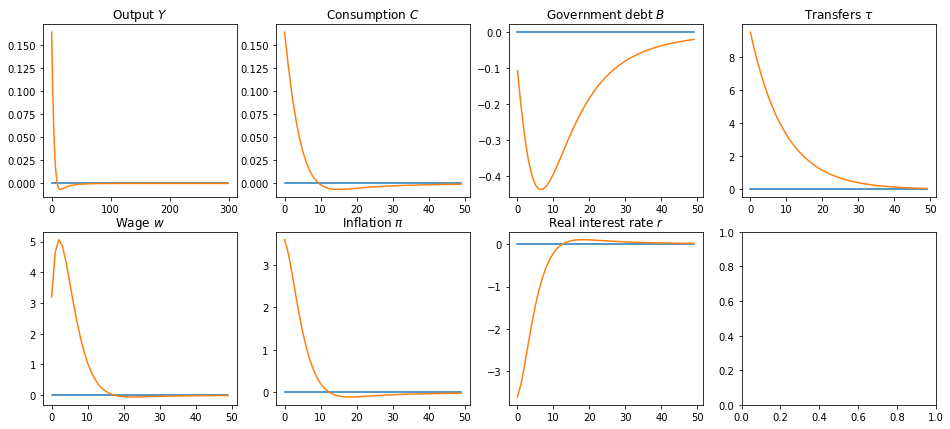

In [36]:
rhos = 0.9
drstar = -0.0025 * 0 * rhos ** (np.arange(T)[:, np.newaxis])
dtstar = 0.00095 * rhos ** (np.arange(T)[:, np.newaxis])

dY = G['Y']['rstar'] @ drstar
dC = G['C']['rstar'] @ drstar
dN = G['N']['rstar'] @ drstar
dB = G['A']['rstar'] @ drstar
dw = G['w']['rstar'] @ drstar
dpi = G['pi']['rstar'] @ drstar
dr = G['r']['rstar'] @ drstar
#di = G['i']['rstar'] @ drstar

dYt = G['Y']['Transfer'] @ dtstar
dCt = G['C']['Transfer'] @ dtstar
dNt = G['N']['Transfer'] @ dtstar
dBt = G['A']['Transfer'] @ dtstar
dwt = G['w']['Transfer'] @ dtstar
dpit = G['pi']['Transfer'] @ dtstar
drt = G['r']['Transfer'] @ dtstar
#dit = G['i']['Transfer'] @ drstar

plt.rcParams["figure.figsize"] = (16,7)
fig, ax = plt.subplots(2, 4)
l1, = ax[0, 0].plot(100 * dY[:500, :])
l2, = ax[0, 0].plot(100 * dYt[:500, :])
ax[0, 0].set_title(r'Output $Y$')

ax[0, 1].plot(100 * dC[:50, :])
ax[0, 1].plot(100 * dCt[:50, :])
ax[0, 1].set_title(r'Consumption $C$')

ax[0, 2].plot(100 * dB[:50, :])
ax[0, 2].plot(100 * dBt[:50, :])
ax[0, 2].set_title(r'Government debt $B$')

ax[0, 3].plot(10000 * np.zeros(50))
ax[0, 3].plot(10000 * dtstar[:50])
ax[0, 3].set_title(r'Transfers $\tau$')

ax[1, 0].plot(10000 * dw[:50, :])
ax[1, 0].plot(10000 * dwt[:50, :])
ax[1, 0].set_title(r'Wage $w$')

ax[1, 1].plot(10000 * dpi[:50, :])
ax[1, 1].plot(10000 * dpit[:50, :])
ax[1, 1].set_title(r'Inflation $\pi$')

ax[1, 2].plot(10000 * dr[:50, :])
ax[1, 2].plot(10000 * drt[:50, :])
ax[1, 2].set_title(r'Real interest rate $r$')

#ax[1, 3].plot(10000 * di[:50])
#ax[1, 3].plot(10000 * np.zeros(50))
#ax[1, 3].plot(10000 * dit[:50, :])
#ax[1, 3].set_title(r'Nominal interest rate $i$')

#ax.legend((l1, l2), ('MonPol', 'Check'), loc='upper right', shadow=True)
plt.show()